# Thai2fit Language Model Pre-training

The goal of this notebook is to train a language model using the [fast.ai](http://www.fast.ai/) version of [AWD LSTM Language Model](https://arxiv.org/abs/1708.02182), with data from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) last updated February 17, 2019. Using 40M/200k/200k tokens of train-validation-test split, we achieved validation perplexity of **28.71067 with 60,005 embeddings at 400 dimensions**, compared to state-of-the-art as of October 27, 2018 at **42.41 for English WikiText-2 by [Yang et al (2018)](https://arxiv.org/abs/1711.03953)**. To the best of our knowledge, there is no comparable research in Thai language at the point of writing (February 17, 2019).

Our workflow is as follows:

* Retrieve and process [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2) according to [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual)
* Perform 40M/200k/200k tokens of train-validation-test split split
* Minimal text cleaning and tokenization using `newmm` with frozen dictionary (`engine='ulmfit'`) of [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)
* Train language model
* Evaluate model based on perplexity and eyeballing
* Extract embeddings to use as "word2vec"

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from tqdm import tqdm_notebook

from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger

data_path = 'th-all/'
model_path = 'thwiki_data/'

## Text Cleaning

We follow the dataset creation, pre- and post-processing of [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual):

* `ulmfit/create_wikitext.py` - Download thwiki in json format and separate them into 40M/200k/200k tokens of train-validation-test split. Articles with least than 100 tokens are removed. Also perform tokenization with whitespaces as separators.
* `ulmfit/postprocess_wikitext.py` - Replace numbers and replace out-of-vocabulary tokens with `xxunk` (frequency of less than 3).

We replaced the Moses Tokenizer with the following code to use [pyThaiNLP](https://github.com/pyThaiNLP/pythainlp/)'s `newmm` dictionary-based tokenizer with a frozen dictionary instead. We join the tokens within an article together to be tokenized later by the data bunch.

In [2]:
from pythainlp.tokenize import word_tokenize
class ThaiNLPTokenizer:
    def __init__(self,engine='ulmfit'):
        self.engine='ulmfit'
    def tokenize(self, t, return_str=True):
        res = word_tokenize(t,self.engine)
        return '|'.join(res) if return_str else res

Here is the statistics of the dataset:

```
before postprocessing
# documents: 121,027. # tokens: 39,378,410

after postprocessing
OOV ratio: 0.0042
data/wiki/th-all vocab size: 111,224
th.wiki.train.tokens. # of tokens: 41,482,435
th.wiki.valid.tokens. # of tokens: 200,563
th.wiki.test.tokens. # of tokens: 200,827
```

In [3]:
#snippet from https://github.com/n-waves/ulmfit-multilingual/blob/master/ulmfit/pretrain_lm.py
def istitle(line):
    return len(re.findall(r'^ ?=\|[^=]*\|= ?$', line)) != 0

def read_wiki_articles(filename):
    articles = []
    with open(filename, encoding='utf8') as f:
        lines = f.readlines()
    current_article = []
    for i,line in enumerate(lines):
        current_article.append(line)
        if i < len(lines)-2 and lines[i+1].strip() == "" and istitle(lines[i+2]):
            articles.append("".join(current_article))
            current_article = []
    articles.append("".join(current_article))
    print(f"Wiki text was split to {len(articles)} articles")
    return pd.DataFrame({'texts': np.array(articles, dtype=np.object)})

In [4]:
#last line is corrupted
train_df = read_wiki_articles(f'{data_path}th.wiki.train.tokens').iloc[:-1,:]
valid_df = read_wiki_articles(f'{data_path}th.wiki.valid.tokens').iloc[:-1,:]
test_df = read_wiki_articles(f'{data_path}th.wiki.test.tokens').iloc[:-1,:]
train_df.shape, valid_df.shape, test_df.shape

Wiki text was split to 20497 articles
Wiki text was split to 492 articles
Wiki text was split to 477 articles


((20496, 1), (491, 1), (476, 1))

In [5]:
#join tokens together
train_df['texts'] = train_df.texts.map(lambda x: ''.join(x.split('|')))
valid_df['texts'] = valid_df.texts.map(lambda x: ''.join(x.split('|')))
test_df['texts'] = test_df.texts.map(lambda x: ''.join(x.split('|')))

## Data Preparation

We used the `newmm` engine of `pyThaiNLP` to perform tokenization. Out of randomnum tokens from all of training set, we chose 60,000 embeddings (plus two for unknown and padding) of tokens which appeared more than twice (not typos) in the training set.


We perform the following text processing:

* Fix html tags to plain texts
* Lowercase all English words and if a word is written in all caps, we put it in a lower case and add `xxup` before
* Repetitive characters: Thai usually emphasizes adjectives by repeating the last character such as `อร่อยมากกกกกกก` to `อร่อยมาก xxrep 7 ` so that the word still retains its original form. 
* Normalize character order: for instance `นำ้` to `น้ำ`
* Add spaces around / and #
* Remove multiple spaces and newlines
* Remove empty brackets of all types (`([{`) which might result from cleaning up
* `pyThaiNLP`'s `newmm` word tokenizer with frozen dictionary (`engine ='ulmfit'`)  is used to tokenize the texts.

### Thai Tokenizer

We use the `newmm` tokenizer with a dictionary frozen as of 2018-10-23.

In [6]:
text='วิทยาศาสตร์ดาวเคราะห์เป็นสาขาวิชาที่ศึกษาเกี่ยวกับองค์ประกอบของดาวเคราะห์'
a = word_tokenize(text,engine='ulmfit')
a

['วิทยาศาสตร์',
 'ดาวเคราะห์',
 'เป็น',
 'สาขาวิชา',
 'ที่',
 'ศึกษา',
 'เกี่ยวกับ',
 'องค์ประกอบ',
 'ของ',
 'ดาวเคราะห์']

In [7]:
# #integrated into pythainlp.ulmfit
from pythainlp.ulmfit import *

# from fastai.text.transform import *
# from pythainlp.tokenize import word_tokenize
# from pythainlp.util import normalize as normalize_char_order
# import emoji

# class ThaiTokenizer(BaseTokenizer):
#     """
#     Wrapper around a frozen newmm tokenizer to make it a fastai `BaseTokenizer`.
#     https://docs.fast.ai/text.transform#BaseTokenizer
#     """

#     def __init__(self, lang = "th"):
#         self.lang = lang

#     def tokenizer(self, t):
#         """
#         :meth: tokenize text with a frozen newmm engine
#         :param str t: text to tokenize
#         :return: tokenized text
#         """
#         return word_tokenize(t, engine="ulmfit")

#     def add_special_cases(self, toks):
#         pass

# def replace_rep_after(t):
#     "Replace repetitions at the character level in `t` after the repetition"

#     def _replace_rep(m):
#         c, cc = m.groups()
#         return f"{c} {TK_REP} {len(cc)+1} "

#     re_rep = re.compile(r"(\S)(\1{2,})")
#     return re_rep.sub(_replace_rep, t)


# def rm_useless_newlines(t):
#     "Remove multiple newlines in `t`."
#     return re.sub(r"[\n]{2,}", " ", t)


# def rm_brackets(t):
#     "Remove all empty brackets from `t`."
#     new_line = re.sub(r"\(\)", "", t)
#     new_line = re.sub(r"\{\}", "", new_line)
#     new_line = re.sub(r"\[\]", "", new_line)
#     return new_line

# def ungroup_emoji(toks):
#     "Ungroup emojis"
#     res = []
#     for tok in toks:
#         if emoji.emoji_count(tok) == len(tok):
#             for char in tok:
#                 res.append(char)
#         else:
#             res.append(tok)
#     return res

# def lowercase_all(toks):
#     "lowercase all English words"
#     return [tok.lower() for tok in toks]

# # Preprocessing rules for Thai text
# pre_rules_th = [fix_html, replace_rep_after, normalize_char_order, 
#                 spec_add_spaces, rm_useless_spaces, rm_useless_newlines, rm_brackets]
# post_rules_th = [replace_all_caps, ungroup_emoji, lowercase_all]

### Data Bunch

We trained the language model based on 40M/200k/200k tokens of train-validation-test split from [Thai Wikipedia Dump](https://dumps.wikimedia.org/thwiki/latest/thwiki-latest-pages-articles.xml.bz2). Tokens are generated and numericalized filtering all words with frequency more than 3 and at maximum vocab size of 60,000 (plus unknown and padding tokens). The minimum frequency is selected by looking at the word distribution of all Wikipedia.

In [8]:
# #select all words to see frequency distribution
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=1)]
# data = (ItemLists(model_path, 
#     TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
#     TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
#     .label_for_lm()
#     .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
#     .databunch(bs=64))
# data.sanity_check()

In [9]:
# res = []
# for i in tqdm_notebook(range(train_df.shape[0])):
#     res.append(data.processor[0].process_one(train_df.texts[i]))
# flat_list = [item for sublist in res for item in sublist]
# freq = Counter(flat_list)
# pickle.dump(freq, open(f'{data_path}freq.pkl','wb'))

In [10]:
freq = pickle.load(open(f'{data_path}freq.pkl','rb'))
freq_df = pd.DataFrame.from_dict(freq, orient='index').reset_index()
freq_df.columns = ['token','freq']
freq_df = freq_df.sort_values('freq',ascending=False)
freq_df.head(10)

,token,freq
1,,8011716
13,\n,1097935
214,ใน,653007
27,ที่,592334
34,และ,568725
156,ของ,477324
39,เป็น,433747
116,มี,340871
61,ได้,317103
147,การ,307194


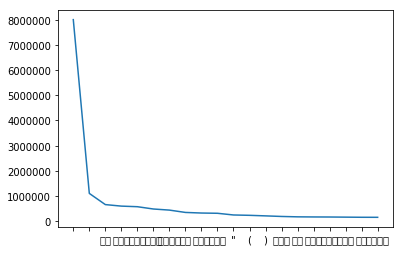

In [11]:
#about 3 is reasonable
plt.plot(freq_df.iloc[:20,:].token,freq_df.iloc[:20,:].freq)

In [12]:
# tt = Tokenizer(tok_func = ThaiTokenizer, lang = 'th', pre_rules = pre_rules_th, post_rules=post_rules_th)
# processor = [TokenizeProcessor(tokenizer=tt, chunksize=10000, mark_fields=False),
#             NumericalizeProcessor(vocab=None, max_vocab=60000, min_freq=3)]

# data = (ItemLists(model_path, 
#     TextList.from_df(train_df, model_path, cols=['texts'], processor=processor),
#     TextList.from_df(valid_df, model_path, cols=['texts'], processor=processor))
#     .label_for_lm()
#     .add_test(TextList.from_df(test_df, model_path, cols=['texts'], processor=processor))
#     .databunch(bs=64))
# data.sanity_check()
# data.save('thwiki_lm_data.pkl')

In [13]:
data = load_data(model_path,'thwiki_lm_data.pkl')
data.sanity_check()
len(data.train_ds), len(data.valid_ds), len(data.test_ds)

(20496, 491, 476)

In [14]:
data.show_batch(5)

idx,text
0,ที่ บ้าน คุณตา คุณยาย ขณะที่ หยุดพัก ใต้ ร่มไม้ ใหญ่ ชายป่า เกิด เจ็บท้อง กะทันหัน และ ได้ คลอด บุตรชาย ออกมา จึง ได้ ตั้ง ชื่อว่า “ เด็กชาย พัก ” \n \n บรรพชา และ อุปสมบท . \n เมื่อ อายุ ๘ ขวบ โยม บิดา ได้ พา เข้า กรุง เทพ
1,ที่ เป็นประโยชน์ ให้ แก่ ประชาชน ส่วนใหญ่ ของ ประเทศ ได้ อย่างแท้จริง และ ยั่งยืน และ จะ ใช้ เทคโนโลยี หรือ สิ่งใด ก็ตาม เพื่อให้ บรรลุ ตาม อุดมการณ์ นี้ โดย พรรค มติ ประชา จะ ขอ ดำเนิน การตาม แนวทาง นี้ เป็น พรรค แรก ใน ประเทศไทย \n \n คำขวัญ ประจำ พรรค . \n พัฒนา ชาติ จาก เสียง ของ ประชาชน
2,น ดา ได้ ตัดหัว ของรัก xxunk เลือด ของ รัต xxunk ก็ จะ หยด ลง สู่ แผ่นดิน แล้ว ผุด ออกมา เป็น ร่าง โคลน อีก นับ ร้อย นับ พัน เมื่อ กำจัด ไม่ได้ พระ แม่ กาลี จึ ได้ ดูด เลือด ของ รัต xxunk ตาม พื้น จน ไม่ ผุด ขึ้น มา อีก ดังนั้น พระ แม่ กาลี จึง โสมนัส มาก บาง ตำรา ก็
3,\n จี ร นันทน์ เศวต นันทน์ นางสาวไทย พ.ศ. 2508 คน ที่ 15 และ ได้รับ ตำแหน่ง รอบ อันดับ 2 นางงาม จักรวาล 1966 สำหรับ จี ร นันทน์ เป็นสาว ไทย คน ที่ 4 ที่ เป็นตัวแทน ของ ประเทศไทย ต่อ จาก อมรา
4,"วิ ฟต์ เป็น ศิลปิน คันทรี คน แรก ที่ ได้ เข้า ชิง รางวัล อัลบั้ม แห่ง ปี สอง ครั้ง ใน คริสต์ ทศวรรษ 2010 \n \n อัลบั้ม ""เรด"" เปิดตัว ที่ อันดับ ที่หนึ่ง บน ชาร์ต บิล บอร์ด 200 เป็น อัลบั้ม ที่สาม ติดต่อกัน ยอดขาย สัปดาห์ แรก ทำได้ 1.21 ล้าน อัลบั้ม เป็น อัลบั้ม ที่สาม"


In [15]:
next(iter(data.test_dl))

[tensor([[   2,    8,   64,  ..., 3053,    8,  388],
         [   8,  888,    8,  ...,    9,    8,   17],
         [2567, 3919,    8,  ...,    8, 7496, 8539],
         ...,
         [  40,   88,   56,  ...,    8,   18,  490],
         [   9,    8,  695,  ...,    9,    8,    9],
         [   8, 9765,    8,  ..., 3978, 5243,   14]], device='cuda:0'),
 tensor([[    8,    64, 11907,  ...,     8,   388,    17],
         [  888,     8,    66,  ...,     8,    17,  1174],
         [ 3919,     8,  2161,  ...,  7496,  8539,  4347],
         ...,
         [   88,    56,    32,  ...,    18,   490,  2178],
         [    8,   695,  2566,  ...,     8,     9,     8],
         [ 9765,     8,     0,  ...,  5243,    14,  8730]], device='cuda:0')]

In [16]:
# pickle.dump(data.vocab.itos, open(f'{model_path}models/thwiki_itos.pkl','wb'))

### Vocab

In [17]:
vocab_lm = data.vocab
vocab_lm.numericalize(word_tokenize('สวัสดีครับพี่น้อง', engine='ulmfit'))

[10205, 7228, 1362]

In [18]:
vocab_lm.textify([10205, 7228, 1362])

'สวัสดี ครับ พี่น้อง'

## Language Modeling

We train the language model according to the [ULMFit paper](https://arxiv.org/abs/1801.06146). We use the name hyperparameters as [n-waves/ulmfit-multilingual](https://github.com/n-waves/ulmfit-multilingual).

In [19]:
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
learn.callback_fns += [partial(CSVLogger, filename="logs")]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03


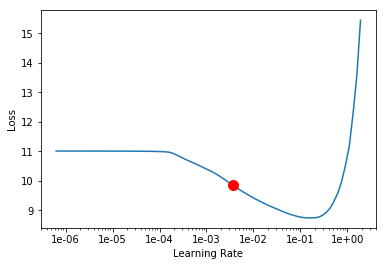

In [20]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
# learn.freeze_to(-1)
# learn.fit_one_cycle(1, 1e-2, moms=(0.8, 0.7))

In [ ]:
# learn.unfreeze()
# learn.fit_one_cycle(20, 1e-3, moms=(0.8, 0.7))

| epoch | train_loss | valid_loss | accuracy |
|-------|------------|------------|----------|
| 1     | 4.839475   | 4.721292   | 0.310731 |
| 2     | 4.446178   | 4.334116   | 0.339528 |
| 3     | 4.20252    | 4.077124   | 0.358266 |
| 4     | 3.987436   | 3.934665   | 0.368153 |
| 5     | 3.892467   | 3.840204   | 0.374417 |
| 6     | 3.831662   | 3.763167   | 0.381314 |
| 7     | 3.709882   | 3.69202    | 0.386698 |
| 8     | 3.647422   | 3.637267   | 0.392416 |
| 9     | 3.613998   | 3.580626   | 0.397986 |
| 10    | 3.575418   | 3.540265   | 0.401437 |
| 11    | 3.487604   | 3.503857   | 0.405754 |
| 12    | 3.399339   | 3.470132   | 0.409309 |
| 13    | 3.397312   | 3.440269   | 0.412976 |
| 14    | 3.372005   | 3.415879   | 0.41563  |
| 15    | 3.340701   | 3.396946   | 0.418529 |
| 16    | 3.26355    | 3.380132   | 0.42015  |
| 17    | 3.299646   | 3.367599   | 0.42148  |
| 18    | 3.235276   | 3.361621   | 0.422451 |
| 19    | 3.258737   | 3.35762    | 0.422644 |
| 20    | 3.260471   | 3.357269   | 0.422881 |

### Eyeballing Test
We perform eyeballing test by having the model "fill in the blanks".

In [1]:
from pythainlp.ulmfit import *
from fastai import *    
from fastai.text import * 
from fastai.callbacks import CSVLogger
data_path = 'th-all-unk/'
model_path = 'thwiki_data/'

#data
data = load_data(model_path,'thwiki_lm_data.pkl')
data.sanity_check()

#lm
config = dict(emb_sz=400, n_hid=1550, n_layers=4, pad_token=1, qrnn=False, tie_weights=True, out_bias=True,
             output_p=0.25, hidden_p=0.1, input_p=0.2, embed_p=0.02, weight_p=0.15)
trn_args = dict(drop_mult=0.9, clip=0.12, alpha=2, beta=1)

learn = language_model_learner(data, AWD_LSTM, config=config, pretrained=False, **trn_args)
learn.opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

#load weights
learn.load('thwiki_lm');

In [3]:
learn.predict('สวัสดีครับพี่น้องเสื้อ',100, sep='', temperature = 0.5)

'สวัสดีครับพี่น้องเสื้อแดง= \n พระจันทร์คู่แดงรักใต้ \n \n พระจันทร์กับใครร้อยล้าน เป็นละครโทรทัศน์ไทยแนวดราม่า จากบทประพันธ์ของ พิมพ์มาดา พัฒนอลงกรณ์ บทโทรทัศน์โดย จิระ มะลิกุล กำกับการแสดงโดย พระเจ้าวรวงศ์เธอ พระองค์เจ้าภาณุพันธุ์ยุคล นำแสดงโดย ณเดชน์ คูกิมิยะ, โอลิเวอร์ พูพาร์ท, จิรศักดิ์ ศิริจรรยา, รัชนก ศรีโลพันธุ์, '

## Embeddings

We extract the embedding layer of the encoder to be used in the same manner as `word2vec`. We can also create sentence vector by summing or averaging the vectors. For more details about `word2vec` use cases, see`word2vec_examples.ipynb`. Note that we use word vectors from `v0.1` since it was trained specifically for the purpose and has comparable dimensions to `fastText` embeddings.

### Extract

In [4]:
#how we extracted the embeddings
emb_weights = list(learn.model.named_parameters())[0][1]
emb_np = to_np(emb_weights.data)
emb_np.shape

(60005, 400)

In [45]:
import string
thai2vec = pd.DataFrame(emb_np)
thai2vec.index = data.vocab.itos
print(thai2vec.shape)
thai2vec.tail(20)

(60005, 400)


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
wellesley,-0.067734,0.072654,-0.035366,0.096368,0.037530,-0.307136,1.029287,0.050824,-0.001017,-0.027416,...,-0.020946,-0.031802,0.193591,-0.306033,-0.098339,-0.106612,0.178221,-0.390134,0.137709,-0.206198
neither,0.052322,0.131118,-0.019800,0.036394,-0.173451,-0.142728,0.888435,-0.213014,-0.068666,0.084319,...,0.110615,0.026936,0.171368,-0.315337,-0.082171,-0.156378,0.152426,-0.498084,0.152074,-0.058838
morton,-0.034595,0.051814,0.078904,0.056833,-0.101619,-0.258944,0.962556,-0.060828,-0.098965,0.067046,...,-0.144449,-0.016442,0.169059,-0.398798,0.007822,0.024065,0.223414,-0.361983,0.123719,-0.047443
รูปการณ์,0.170740,0.037356,0.064198,0.221384,-0.133751,-0.080735,1.023113,-0.215145,-0.174581,-0.061226,...,0.149384,0.005873,0.055502,-0.307415,0.046223,-0.082850,0.176578,-0.513099,0.039629,-0.096573
เอ็ตส์,0.089464,0.090325,-0.007161,0.159508,-0.121201,-0.003137,0.873845,-0.066796,-0.019356,-0.032459,...,0.062420,0.005237,0.180440,-0.172255,-0.011022,-0.152557,0.224190,-0.315444,0.168196,-0.084524
ฎก,-0.049585,0.095254,0.128838,0.093145,0.056116,-0.142487,0.927257,0.011548,-0.064591,0.004499,...,0.131102,-0.088658,0.264789,-0.241429,-0.151655,-0.034233,0.418429,-0.259111,0.143246,0.026044
sinners,-0.067370,0.057247,0.018062,0.088009,-0.153709,-0.186801,0.933545,-0.052297,0.037983,-0.119578,...,-0.104894,-0.000512,0.285256,-0.330760,-0.064316,0.048416,0.232367,-0.614341,0.166118,-0.054796
กรมส่งเสริมสหกรณ์,0.262246,0.048866,0.140255,0.155343,-0.000695,-0.352118,1.159076,0.025188,-0.150442,-0.017149,...,-0.126095,-0.084117,0.190851,-0.511947,0.099128,-0.142185,0.508278,-0.565020,0.089897,-0.128713
stains,0.049079,0.230003,0.000788,0.115999,-0.160390,-0.120605,1.059330,-0.113979,-0.112892,0.037003,...,-0.055166,-0.109285,0.150294,-0.234296,0.000003,-0.122947,0.279522,-0.461792,0.106195,-0.028563
jae,-0.099796,0.160105,0.036737,0.147844,-0.016049,-0.154602,1.069676,-0.035392,-0.168951,-0.016280,...,-0.017641,0.041653,0.152065,-0.263338,-0.080744,-0.101456,0.306006,-0.478414,0.222499,-0.256096


In [70]:
#filter out space and punctuatings
symbols = string.punctuation + '\n' + ' '
symbol_idx = np.array([np.sum([char in symbols for char in word])>0 for word in data.vocab.itos])
thai2vec[symbol_idx].shape

(4281, 400)

In [71]:
thai2save = thai2vec[~symbol_idx].iloc[9:,:]
print(thai2save.shape)
thai2save.head(10)

(55715, 400)


,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
ที่,-0.695129,0.072135,0.110245,0.451211,-0.159222,-0.895408,1.008484,0.528633,0.028199,-0.111075,...,0.528622,-0.072051,0.305300,-1.211560,0.076295,-0.199828,0.149318,-0.144456,0.318454,-0.008195
และ,-0.472370,0.103458,-0.058700,0.225169,-0.161821,-0.474367,0.915293,-0.040432,0.219998,-0.121170,...,-0.021196,-0.068306,0.368672,-0.932151,0.127423,-0.161117,0.337690,-0.089959,0.120180,-0.013983
ของ,-0.938725,0.167786,-0.250770,0.330679,-0.206076,-1.053770,0.919519,-0.152319,-0.229686,-0.302734,...,0.461007,-0.221972,-0.025834,-1.076673,-0.135065,-0.088723,0.124322,-0.210358,0.113249,-0.037509
เป็น,0.106212,0.069043,-0.060668,-0.169796,-0.041796,-0.705916,0.949469,-0.172663,-0.222472,-0.186052,...,0.167475,-0.081394,0.447960,-2.061203,-0.165172,-0.083664,0.252981,-0.263083,0.232104,-0.032581
มี,0.210529,0.098669,-0.220604,0.192171,-0.100841,-0.117660,0.998566,-0.288853,-0.880610,0.056140,...,-0.070651,-0.169024,0.340016,0.983595,-0.195659,-0.151123,0.180130,-0.519779,0.095921,-0.094529
ได้,0.024035,0.172333,-0.321161,0.455705,-0.359382,-0.854560,0.834913,-0.432461,-0.634329,-0.152447,...,0.391850,-0.167563,0.369804,-1.382373,-0.565057,-0.174070,0.251388,-0.763839,-0.121391,0.113892
การ,0.085726,0.113309,-0.113307,0.183015,-0.203529,0.584868,1.058635,-0.317441,-0.710107,0.458324,...,0.311799,-0.105078,-0.021419,0.070404,0.142509,-0.256120,0.195995,-0.852968,0.116529,-0.018800
โดย,-0.181905,0.284542,0.555495,0.179171,-0.474573,-0.275702,0.879816,0.281031,0.677351,-0.004784,...,0.843834,-0.195481,0.191318,-1.181023,0.112748,-0.110170,0.144586,-0.448395,-0.161289,0.104909
จะ,0.332298,0.006531,-0.082011,0.471008,-0.547712,-0.926136,0.976552,-0.151353,-0.901804,-0.370847,...,0.185248,-0.061064,0.256089,0.633278,0.074008,0.193003,-0.003842,-0.808760,-0.029369,-0.008169
กับ,-0.066276,0.152619,-0.464675,-0.052286,-0.423653,-0.874687,0.703685,-0.127358,0.553087,-0.095037,...,-0.703104,-0.310687,-0.338449,-1.241768,0.157311,-0.245116,0.562296,-0.295879,-0.315580,-0.119429


In [72]:
thai2save.tail(10)

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
stains,0.049079,0.230003,0.000788,0.115999,-0.160390,-0.120605,1.059330,-0.113979,-0.112892,0.037003,...,-0.055166,-0.109285,0.150294,-0.234296,0.000003,-0.122947,0.279522,-0.461792,0.106195,-0.028563
jae,-0.099796,0.160105,0.036737,0.147844,-0.016049,-0.154602,1.069676,-0.035392,-0.168951,-0.016280,...,-0.017641,0.041653,0.152065,-0.263338,-0.080744,-0.101456,0.306006,-0.478414,0.222499,-0.256096
ตำรวจน้ำ,0.231749,0.075508,0.058714,0.114546,-0.031199,-0.344983,1.092970,0.055949,-0.138212,0.097456,...,-0.005965,-0.106436,0.095294,-0.309038,0.041019,-0.165651,0.193417,-0.604129,0.009567,-0.120696
พว,0.075476,0.102602,-0.035957,0.100443,-0.200286,-0.261037,1.028585,-0.033196,-0.068074,0.005245,...,-0.036334,-0.032790,0.158513,-0.283554,0.011465,-0.066830,0.351123,-0.483461,0.202977,-0.126523
mexicana,0.019365,0.137165,0.016300,0.113440,-0.061739,-0.075280,0.889068,-0.126024,0.025905,-0.139118,...,0.021086,-0.111228,0.188737,-0.218721,-0.189438,-0.046380,0.244375,-0.463973,0.048097,-0.126826
mamacita,0.124321,0.039705,0.104062,0.083874,-0.089720,-0.095827,0.766905,0.063875,-0.171166,-0.008717,...,0.065087,-0.185896,0.211701,-0.311197,-0.015919,-0.130126,0.324933,-0.356846,0.118780,-0.059525
loaded,-0.078538,0.135751,0.041390,0.233966,-0.073196,-0.192612,1.177646,0.155496,-0.294270,0.055089,...,-0.037558,-0.065520,0.376273,-0.289788,-0.070625,-0.104340,0.279783,-0.662054,0.120185,-0.090692
coyote,-0.105001,0.058455,-0.026541,0.071663,-0.046507,-0.094318,0.915186,-0.019707,-0.092782,-0.011009,...,0.030423,-0.076641,0.121034,-0.232003,0.014622,-0.029179,0.216015,-0.439991,0.049715,-0.144805
อั๊ก,-0.030914,0.114261,-0.079358,0.041814,-0.153318,-0.130539,0.991144,-0.061294,-0.058954,-0.087997,...,0.053892,-0.023647,0.059137,-0.127566,0.101460,-0.056661,0.226744,-0.523050,0.173694,-0.075106
ตะกุย,-0.022116,0.094815,-0.039665,0.025395,-0.028602,-0.142825,0.896260,-0.158197,0.004577,-0.101853,...,0.119742,-0.017604,0.245836,-0.290306,0.038032,-0.001618,0.419915,-0.250596,0.291778,-0.228616


In [73]:
# thai2save.to_csv(f'{model_path}models/thai2vec.vec',sep=' ',header=False, line_terminator='\n')

In [76]:
from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format(f'{model_path}models/thai2vec.vec',binary=False,
                                         unicode_errors = 'ignore')

In [77]:
# model.save_word2vec_format(f'{model_path}models/thai2vec.vec',f'{model_path}models/thai2vec.vocab',False)
# model.save_word2vec_format(f'{model_path}models/thai2vec.bin',None,True)

## Document Vectors

We can also get document vector from the language model by applying the encoder to a sentence.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tt = ThaiTokenizer()
def document_vector(ss, learn, data):
    s = tt.tokenizer(ss)
    t = torch.tensor(data.vocab.numericalize(s), requires_grad=False).to(device)
    m = learn.model[0].encoder.to(device)
    res = m(t).mean(0).cpu().detach().numpy()
    return(res)

In [ ]:
ss = 'วันนี้วันดีปีใหม่'
document_vector(ss,learn,data)

In [ ]:
from pythainlp.ulmfit import *
document_vector('วันนี้วันดีปีใหม่',learn,data)